In [1]:
!pip install tsfel scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.3 MB/s eta 0:00:00


In [2]:
#Import Libraries
import os
import numpy as np
import pandas as pd
import tsfel
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
# defining functions to load the raw inertial signals and labels
''' loading the nine inertial signal files (accelerometer and gyroscope data).
    Each signal is reshaped to (samples, 128, 1)
    and concatenated to form a (samples, 128, 9) array.'''
def load_signals(folder, dataset='train'):
    signals = []
    signal_files = [
        f"total_acc_x_{dataset}.txt", f"total_acc_y_{dataset}.txt", f"total_acc_z_{dataset}.txt",
        f"body_acc_x_{dataset}.txt", f"body_acc_y_{dataset}.txt", f"body_acc_z_{dataset}.txt",
        f"body_gyro_x_{dataset}.txt", f"body_gyro_y_{dataset}.txt", f"body_gyro_z_{dataset}.txt"
    ]
    for file in signal_files:
        filepath = os.path.join(folder, "Inertial Signals", file)
        # Each file contains rows corresponding to a sample; each row has 128 readings
        signal = np.loadtxt(filepath).reshape(-1, 128, 1)
        signals.append(signal)
    # Concatenate along the last axis to form (samples, 128, 9)
    return np.concatenate(signals, axis=-1)
"""
below function loads the activity labels from a text file and returns them as a numpy array.
"""
def load_labels(filepath):
    return np.loadtxt(filepath, dtype=int)

In [4]:
import zipfile
import os
zip_path = "/content/UCI_HAR_Dataset[1].zip"
extract_path = "/content/data"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzipping completed and  files are extracted to:", extract_path)


Unzipping completed and  files are extracted to: /content/data


In [5]:
# Defining dataset paths.
train_folder = "/content/data/UCI HAR Dataset/train"
test_folder = "/content/data/UCI HAR Dataset/test"
# Loading raw inertial signals for train and test datasets
train_signals = load_signals(train_folder, dataset='train')
test_signals = load_signals(test_folder, dataset='test')
# Loading corresponding labels
train_labels = load_labels(os.path.join(train_folder, "y_train.txt"))
test_labels = load_labels(os.path.join(test_folder, "y_test.txt"))

In [6]:
# now using TSFEL to generate features from the inertial signals
# getting the default configuration (this configuration extracts features from time series data)
cfg = tsfel.get_features_by_domain()
"""
    below function extracts TSFEL features for each sample in signals_array.
    Each sample is a (128, 9) array. I converted it to a DataFrame (9 columns)
    and extracted features for each sample using TSFEL which then
    returns a numpy array where each row is the feature vector for one sample.
"""
def extract_tsfel_features(signals_array):

    features_list = []
    for sample in tqdm(signals_array, desc="Extracting TSFEL features"):
        # Create a DataFrame with each channel as a column (names can be arbitrary)
        df_sample = pd.DataFrame(sample, columns=[f"ch{i}" for i in range(sample.shape[1])])
        # tsfel returns a DataFrame with one row of features
        feats = tsfel.time_series_features_extractor(cfg, df_sample, fs=50, verbose=0)
        features_list.append(feats.values.flatten())
    return np.array(features_list)

# Generate TSFEL features for training and testing data
X_train_tsfel = extract_tsfel_features(train_signals)
X_test_tsfel = extract_tsfel_features(test_signals)

Extracting TSFEL features: 100%|██████████| 2947/2947 [06:03<00:00,  8.11it/s]


In [7]:
# Loading the provided feature vectors (extracted by the authors)
# These files (X_train.txt and X_test.txt) contain the 561 pre-computed features.
X_train_provided = np.loadtxt(os.path.join(train_folder, "X_train.txt"))
X_test_provided = np.loadtxt(os.path.join(test_folder, "X_test.txt"))

In [10]:
#now defining a helper function to train and evaluate models with scaling.
"""
    below function trains three classifiers (Random Forest, SVM, Logistic Regression) which was
     mentioned in the doc on the provided features
    and evaluates them on the test set. Each classifier is wrapped in a pipeline with StandardScaler and it
    returns a dictionary of accuracies.
"""
def evaluate_models(X_train, y_train, X_test, y_test):

    models = {
        "Random Forest": Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(
                n_estimators=500,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            ))
        ]),
        "SVM": Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(
                kernel='rbf',
                C=10,
                gamma='auto',
                class_weight='balanced',
                random_state=42,
                max_iter=10000
            ))
        ]),
         "Logistic Regression": Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(max_iter=10000, random_state=42))
        ])
    }
    results = {}
    for name, model in models.items():
        print(f"Training {name} ...")
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        results[name] = acc
        print(f"--- {name} Accuracy: {acc:.4f} ---")
        print(classification_report(y_test, preds))
        print("-" * 40)
    return results

In [11]:
# Training and evaluating models on TSFEL-generated features
print("Evaluating using TSFEL Generated Features")
results_tsfel = evaluate_models(X_train_tsfel, train_labels, X_test_tsfel, test_labels)

Evaluating using TSFEL Generated Features
Training Random Forest ...
--- Random Forest Accuracy: 0.9308 ---
              precision    recall  f1-score   support

           1       0.93      0.99      0.96       496
           2       0.89      0.95      0.92       471
           3       0.96      0.83      0.89       420
           4       0.89      0.90      0.90       491
           5       0.91      0.90      0.90       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

----------------------------------------
Training SVM ...
--- SVM Accuracy: 0.9566 ---
              precision    recall  f1-score   support

           1       0.95      0.98      0.96       496
           2       0.98      0.95      0.97       471
           3       0.96      0.97      0.97       420
           4       0.95      0.88      0.92  

In [12]:
# Training and evaluating models on provided (author-extracted) features
print("Evaluating using Provided Features")
results_provided = evaluate_models(X_train_provided, train_labels, X_test_provided, test_labels)

Evaluating using Provided Features
Training Random Forest ...
--- Random Forest Accuracy: 0.9287 ---
              precision    recall  f1-score   support

           1       0.89      0.97      0.93       496
           2       0.90      0.91      0.90       471
           3       0.96      0.84      0.90       420
           4       0.93      0.89      0.91       491
           5       0.90      0.94      0.92       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

----------------------------------------
Training SVM ...
--- SVM Accuracy: 0.9549 ---
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       496
           2       0.93      0.96      0.95       471
           3       0.97      0.92      0.94       420
           4       0.96      0.90      0.93       49

In [13]:
# now comparing and displaying the results
print("Comparison of Model Performance:")
print("TSFEL Features:")
for model_name, acc in results_tsfel.items():
    print(f"{model_name}: {acc:.4f}")
print("\nProvided Features:")
for model_name, acc in results_provided.items():
    print(f"{model_name}: {acc:.4f}")

Comparison of Model Performance:
TSFEL Features:
Random Forest: 0.9308
SVM: 0.9566
Logistic Regression: 0.9562

Provided Features:
Random Forest: 0.9287
SVM: 0.9549
Logistic Regression: 0.9549


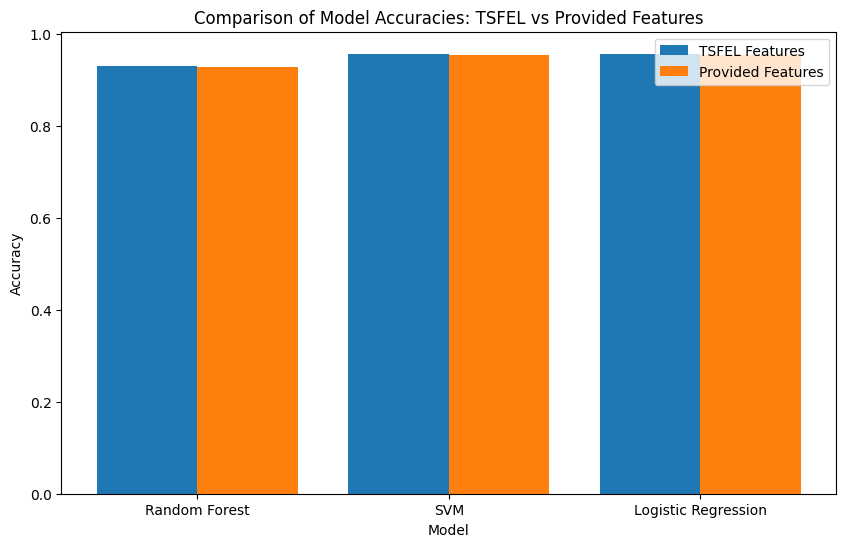

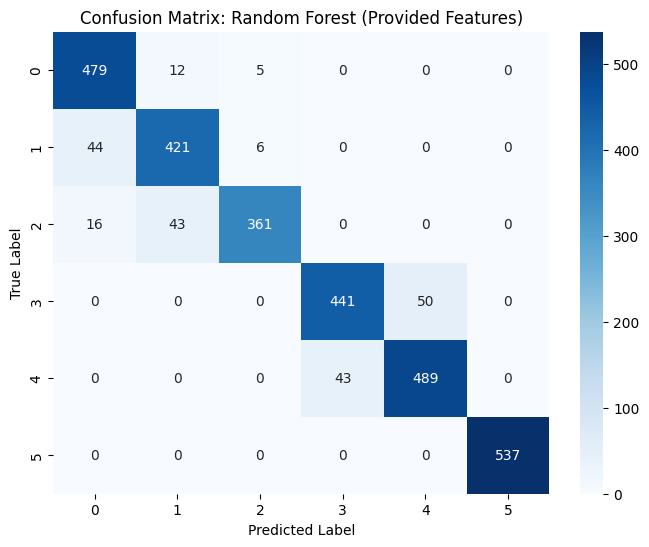

In [14]:
# Visualization part:- Comparring  Bar Chart for Model Accuracies.
# we have assumed that results_tsfel and results_provided are dictionaries with model names as keys and accuracies as values.
model_names = list(results_tsfel.keys())
tsfel_accuracies = [results_tsfel[m] for m in model_names]
provided_accuracies = [results_provided[m] for m in model_names]
x = range(len(model_names))
plt.figure(figsize=(10, 6))
plt.bar([i - 0.2 for i in x], tsfel_accuracies, width=0.4, label="TSFEL Features")
plt.bar([i + 0.2 for i in x], provided_accuracies, width=0.4, label="Provided Features")
plt.xticks(x, model_names)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies: TSFEL vs Provided Features")
plt.legend()
plt.show()
# now visualizing: Confusion Matrix for Random Forest (using Provided Features)
from sklearn.ensemble import RandomForestClassifier
# Fitting a Random Forest classifier on the provided features.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_provided, train_labels)
rf_preds = rf_model.predict(X_test_provided)
# and at last Computing confusion matrix
cm = confusion_matrix(test_labels, rf_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Random Forest (Provided Features)")
plt.show()
